In [2]:
# import table
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.ticker as mtick
import seaborn as sns
import json
%matplotlib inline

from pm4py.objects.log.importer.xes import importer
from pm4py.algo.filtering.log.variants import variants_filter
from pm4py.algo.discovery.inductive.variants.im_f import algorithm as im_f_algo
from pm4py.algo.evaluation.precision import algorithm as precision_evaluator
from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness_evaluator

from dpv.util.converter import param_transform, downscale, merge
from dpv.variant_transformer import private_transform, public_transform
from dpv.variant_query import variant_query
from dpv.optimizer import release_optimizer
from dpv.data_utility import emd_utility, log_diff

In [2]:
# import xes event log (BPIC13 example)
log = importer.apply('BPIC13.xes')

# process model from xes log
net1, im1, fm1 = im_f_algo.apply(log, parameters=None)

parsing log, completed traces :: 100%|██████████| 7554/7554 [00:01<00:00, 4613.28it/s]


In [3]:
# load data
eps_list = [2, 1, 0.1, 0.01]
del_list = ['0.01', '0.001', '0.0001', '0.00001', '0.000001']
util_gan = np.zeros((len(eps_list), len(del_list)))
cost_gan = np.zeros((len(eps_list), len(del_list)))

# compute and save data utility metrics
for m, eps in enumerate(eps_list):
    for n, d in enumerate(del_list):
        
        f = open(f'logs/variants_gan_{eps}_{d}.json',)
        priv_log = json.load(f)
        util_gan[m][n] = emd_utility(log, priv_log)
        cost_gan[m][n] = log_diff(log, priv_log)
        f.close()

        print(f'eps: {eps}, delta: {d}, util: {util_gan[m][n]}, cost: {cost_gan[m][n]}')
        

np.savetxt('logs/util_gan.txt', util_gan)
np.savetxt('logs/cost_gan.txt', cost_gan)

eps: 2, delta: 0.01, util: 0.7789543118469718, cost: 69028.0
eps: 2, delta: 0.001, util: 0.8043348194549729, cost: 53468.0
eps: 2, delta: 0.0001, util: 0.7995885564799681, cost: 53783.0
eps: 2, delta: 0.00001, util: 0.7738420988079694, cost: 61659.0
eps: 2, delta: 0.000001, util: 0.8011615791269684, cost: 58014.0
eps: 1, delta: 0.01, util: 0.8027013256879684, cost: 55254.0
eps: 1, delta: 0.001, util: 0.7826992889249718, cost: 61890.0
eps: 1, delta: 0.0001, util: 0.7760067976299697, cost: 58578.0
eps: 1, delta: 0.00001, util: 0.7949965792149735, cost: 54543.0
eps: 1, delta: 0.000001, util: 0.7937265387459708, cost: 52330.0
eps: 0.1, delta: 0.01, util: 0.66857168338797, cost: 79848.0
eps: 0.1, delta: 0.001, util: 0.6026550234749743, cost: 88980.0
eps: 0.1, delta: 0.0001, util: 0.5354924363169713, cost: 98239.0
eps: 0.1, delta: 0.00001, util: 0.5249040406389716, cost: 108896.0
eps: 0.1, delta: 0.000001, util: 0.600633633711974, cost: 88002.0
eps: 0.01, delta: 0.01, util: 0.479643281517971

In [4]:
# load data
eps_list = [2, 1, 0.1, 0.01]
del_list = ['0.01', '0.001', '0.0001', '0.00001', '0.000001']
fit_gan_dp = np.zeros((len(eps_list), len(del_list)))
fit_gan_nondp = np.zeros((len(eps_list), len(del_list)))
prec_gan_dp = np.zeros((len(eps_list), len(del_list)))
prec_gan_nondp = np.zeros((len(eps_list), len(del_list)))

# compute and save result utility metrics
for m, eps in enumerate(eps_list):
    for n, d in enumerate(del_list):
        
        f = open(f'logs/variants_gan_{eps}_{d}.json',)
        priv_log = json.load(f)
        plog = public_transform(priv_log)
        net, im, fm = im_f_algo.apply(plog, parameters=None)

        fit_gan_dp[m][n] = replay_fitness_evaluator.apply(log, net, im, fm, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)['log_fitness']
        fit_gan_nondp[m][n] = replay_fitness_evaluator.apply(plog, net1, im1, fm1, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)['log_fitness']
        prec_gan_dp[m][n] = precision_evaluator.apply(log, net, im, fm, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
        prec_gan_nondp[m][n] = precision_evaluator.apply(plog, net1, im1, fm1, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
        
        f.close()

        print(f'eps: {eps}, delta: {d}, prec: {prec_gan_dp[m][n]}, fit: {fit_gan_dp[m][n]}')


np.savetxt('logs/fit_gan_dp.txt', fit_gan_dp)
np.savetxt('logs/fit_gan_nondp.txt', fit_gan_nondp)
np.savetxt('logs/prec_gan_dp.txt', prec_gan_dp)
np.savetxt('logs/prec_gan_nondp.txt', prec_gan_nondp)

replaying log with TBR, completed variants :: 100%|██████████| 2384/2384 [00:03<00:00, 625.61it/s]


eps: 2, delta: 0.01, prec: 0.8587648335541337, fit: 0.9998189317858626


replaying log with TBR, completed variants :: 100%|██████████| 2206/2206 [00:03<00:00, 615.18it/s]


eps: 2, delta: 0.001, prec: 0.8307214177081267, fit: 0.9998759820666492


replaying log with TBR, completed variants :: 100%|██████████| 2028/2028 [00:03<00:00, 602.75it/s]


eps: 2, delta: 0.0001, prec: 0.8849017985454862, fit: 0.9999149079397848


replaying log with TBR, completed variants :: 100%|██████████| 2484/2484 [00:04<00:00, 535.85it/s]


eps: 2, delta: 0.00001, prec: 0.8766741071428571, fit: 0.9946449064573959


replaying log with TBR, completed variants :: 100%|██████████| 2164/2164 [00:04<00:00, 512.48it/s]


eps: 2, delta: 0.000001, prec: 0.8766741071428571, fit: 0.9946449064573959


replaying log with TBR, completed variants :: 100%|██████████| 2676/2676 [00:04<00:00, 605.28it/s]


eps: 1, delta: 0.01, prec: 0.8766741071428571, fit: 0.9946449064573959


replaying log with TBR, completed variants :: 100%|██████████| 2094/2094 [00:03<00:00, 612.25it/s]


eps: 1, delta: 0.001, prec: 0.8849017985454862, fit: 0.9999149079397848


replaying log with TBR, completed variants :: 100%|██████████| 2409/2409 [00:04<00:00, 533.14it/s]


eps: 1, delta: 0.0001, prec: 0.8307214177081267, fit: 0.9998759820666492


replaying log with TBR, completed variants :: 100%|██████████| 2328/2328 [00:03<00:00, 624.47it/s]


eps: 1, delta: 0.00001, prec: 0.8766741071428571, fit: 0.9946449064573959


replaying log with TBR, completed variants :: 100%|██████████| 1964/1964 [00:03<00:00, 653.58it/s]


eps: 1, delta: 0.000001, prec: 0.8766741071428571, fit: 0.9946449064573959


replaying log with TBR, completed variants :: 100%|██████████| 2364/2364 [00:03<00:00, 607.38it/s]


eps: 0.1, delta: 0.01, prec: 0.8307214177081267, fit: 0.9578553752609318


replaying log with TBR, completed variants :: 100%|██████████| 1830/1830 [00:02<00:00, 621.18it/s]


eps: 0.1, delta: 0.001, prec: 0.8218533717155632, fit: 0.970172590729326


replaying log with TBR, completed variants :: 100%|██████████| 1962/1962 [00:03<00:00, 597.35it/s]


eps: 0.1, delta: 0.0001, prec: 0.8587648335541337, fit: 0.9998189317858626


replaying log with TBR, completed variants :: 100%|██████████| 2035/2035 [00:03<00:00, 558.86it/s]


eps: 0.1, delta: 0.00001, prec: 0.8587648335541337, fit: 0.9997580521718521


replaying log with TBR, completed variants :: 100%|██████████| 2524/2524 [00:04<00:00, 563.77it/s]


eps: 0.1, delta: 0.000001, prec: 0.9236108179308132, fit: 0.9205241722575872


replaying log with TBR, completed variants :: 100%|██████████| 261/261 [00:00<00:00, 709.48it/s]


eps: 0.01, delta: 0.01, prec: 0.8604790254499457, fit: 0.9945399771207722


replaying log with TBR, completed variants :: 100%|██████████| 236/236 [00:00<00:00, 575.31it/s]


eps: 0.01, delta: 0.001, prec: 0.8604790254499457, fit: 0.9945399771207722


replaying log with TBR, completed variants :: 100%|██████████| 307/307 [00:00<00:00, 667.33it/s]


eps: 0.01, delta: 0.0001, prec: 0.8604790254499457, fit: 0.9945399771207722


replaying log with TBR, completed variants :: 100%|██████████| 249/249 [00:00<00:00, 721.21it/s]


eps: 0.01, delta: 0.00001, prec: 0.8604790254499457, fit: 0.9945399771207722


replaying log with TBR, completed variants :: 100%|██████████| 244/244 [00:00<00:00, 676.30it/s]

eps: 0.01, delta: 0.000001, prec: 0.8604790254499457, fit: 0.9945399771207722


In [3]:
# load data for plotting
util_gan = np.loadtxt('logs/util_gan.txt')
util_trav = np.maximum(np.loadtxt('logs/util_opt.txt'),np.loadtxt('logs/util_sqvr.txt'))
util_bench = np.loadtxt('logs/util_bench.txt')
cost_gan = np.loadtxt('logs/cost_gan.txt') 
cost_trav = np.minimum(np.loadtxt('logs/cost_opt.txt'),np.loadtxt('logs/cost_sqvr.txt'))
cost_bench = np.loadtxt('logs/cost_bench.txt')
fit_gan_dp = np.loadtxt('logs/fit_gan_dp.txt')
fit_gan_nondp = np.loadtxt('logs/fit_gan_nondp.txt')
fit_trav_dp = np.maximum(np.loadtxt('logs/fit_opt_dp.txt'),np.loadtxt('logs/fit_sqvr_dp.txt'))
fit_trav_nondp = np.maximum(np.loadtxt('logs/fit_opt_nondp.txt'),np.loadtxt('logs/fit_sqvr_nondp.txt'))
fit_bench_dp = np.loadtxt('logs/fit_bench_dp.txt')
fit_bench_nondp = np.loadtxt('logs/fit_bench_nondp.txt')
prec_gan_dp = np.loadtxt('logs/prec_gan_dp.txt')
prec_gan_nondp = np.loadtxt('logs/prec_gan_nondp.txt')
prec_trav_dp = np.maximum(np.loadtxt('logs/prec_opt_dp.txt'),np.loadtxt('logs/prec_sqvr_dp.txt'))
prec_trav_nondp = np.maximum(np.loadtxt('logs/prec_opt_nondp.txt'),np.loadtxt('logs/prec_sqvr_nondp.txt'))
prec_bench_dp = np.loadtxt('logs/prec_bench_dp.txt')
prec_bench_nondp = np.loadtxt('logs/prec_bench_nondp.txt')

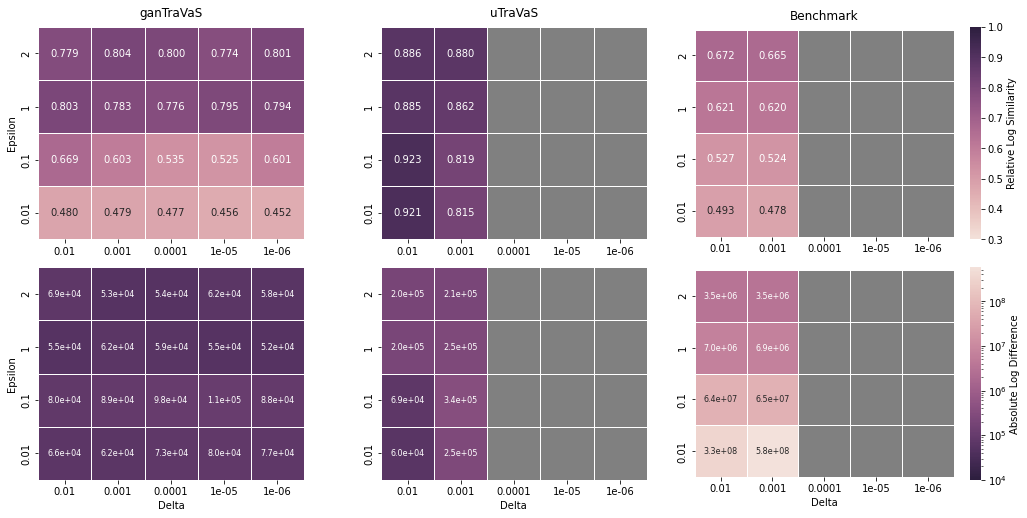

In [7]:
# create plots
f, ax = plt.subplots(2, 3, figsize=(14.8, 7.3))
cmap = sns.cubehelix_palette(as_cmap=True, light=.9)
cmap_r = sns.cubehelix_palette(as_cmap=True, light=.9, reverse=True)
cmap.set_bad('grey', 1.)
cmap_r.set_bad('grey', 1.)
ax[0,0] = sns.heatmap(util_gan, ax=ax[0,0], vmin=0.3, vmax=1, cmap=cmap, square=True, annot=True, cbar=False, fmt='.3f', yticklabels=[2,1,0.1,0.01], xticklabels=[0.01,0.001,0.0001,0.00001,0.000001], linewidths=.5)
ax[0,1] = sns.heatmap(util_trav, ax=ax[0,1], vmin=0.3, vmax=1, cmap=cmap, square=True, annot=True, fmt='.3f', cbar=False, yticklabels=[2,1,0.1,0.01], xticklabels=[0.01,0.001,0.0001,0.00001,0.000001], mask=np.isnan(util_trav), linewidths=.5)
ax[0,2] = sns.heatmap(util_bench, ax=ax[0,2], vmin=0.3, vmax=1, cmap=cmap, square=True, annot=True, fmt='.3f', cbar=True, yticklabels=[2,1,0.1,0.01], xticklabels=[0.01,0.001,0.0001,0.00001,0.000001], mask=np.isnan(util_bench), linewidths=.5, cbar_kws={'label': 'Relative Log Similarity'})
ax[1,0] = sns.heatmap(cost_gan, ax=ax[1,0], cmap=cmap_r, square=True, norm=LogNorm(vmin=1e4, vmax=np.nanmax(cost_bench)), annot=True, cbar=False, fmt='.1e', yticklabels=[2,1,0.1,0.01], xticklabels=[0.01,0.001,0.0001,0.00001,0.000001], linewidths=.5, annot_kws={"fontsize":8})
ax[1,1] = sns.heatmap(cost_trav, ax=ax[1,1], cmap=cmap_r, square=True, norm=LogNorm(vmin=1e4, vmax=np.nanmax(cost_bench)), annot=True, cbar=False, fmt='.1e', yticklabels=[2,1,0.1,0.01], xticklabels=[0.01,0.001,0.0001,0.00001,0.000001], mask=np.isnan(cost_trav), linewidths=.5, annot_kws={"fontsize":8})
ax[1,2] = sns.heatmap(cost_bench, ax=ax[1,2], cmap=cmap_r, norm=LogNorm(vmin=1e4, vmax=np.nanmax(cost_bench)), square=True, annot=True, fmt='.1e', cbar=True, yticklabels=[2,1,0.1,0.01], xticklabels=[0.01,0.001,0.0001,0.00001,0.000001], mask=np.isnan(cost_bench), linewidths=.5, cbar_kws={'label': 'Absolute Log Difference'}, annot_kws={"fontsize":8})
ax[0,0].set_title('ganTraVaS', pad=10)
ax[0,1].set_title('uTraVaS', pad=10)
ax[0,2].set_title('Benchmark', pad=10)
ax[1,0].set(xlabel="Delta", ylabel="Epsilon")
ax[0,0].set(ylabel="Epsilon")
ax[1,1].set(xlabel="Delta")
ax[1,2].set(xlabel="Delta")
f.tight_layout()
plt.savefig("BPIC13_data-util.pdf")

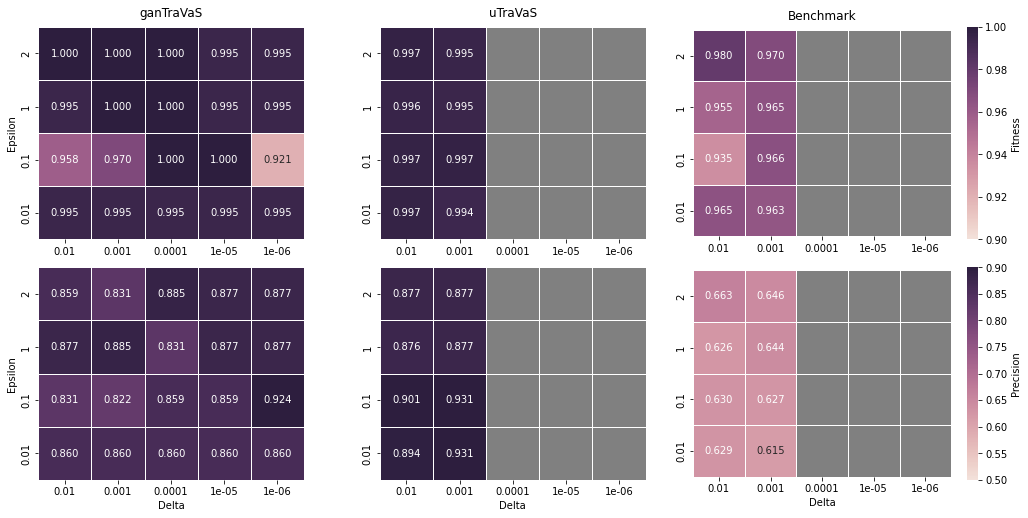

In [10]:
# create plots
f, ax = plt.subplots(2, 3, figsize=(14.8, 7.3))
cmap = sns.cubehelix_palette(as_cmap=True, light=.9)
cmap.set_bad('grey', 1.)
ax[0,0] = sns.heatmap(fit_gan_dp, ax=ax[0,0], vmin=0.9, vmax=1, cmap=cmap, square=True, annot=True, cbar=False, fmt='.3f', yticklabels=[2,1,0.1,0.01], xticklabels=[0.01,0.001,0.0001,0.00001,0.000001], linewidths=.5)
ax[0,1] = sns.heatmap(fit_trav_dp, ax=ax[0,1], vmin=0.9, vmax=1, cmap=cmap, square=True, annot=True, cbar=False, fmt='.3f', yticklabels=[2,1,0.1,0.01], xticklabels=[0.01,0.001,0.0001,0.00001,0.000001], mask=np.isnan(fit_trav_dp), linewidths=.5)
ax[0,2] = sns.heatmap(fit_bench_dp, ax=ax[0,2], vmin=0.9, vmax=1, cmap=cmap, square=True, annot=True, fmt='.3f', cbar=True, yticklabels=[2,1,0.1,0.01], xticklabels=[0.01,0.001,0.0001,0.00001,0.000001], mask=np.isnan(fit_bench_dp), linewidths=.5, cbar_kws={'label': 'Fitness'})
ax[1,0] = sns.heatmap(prec_gan_dp, ax=ax[1,0], cmap=cmap, square=True, vmin=0.5, vmax=0.9, annot=True, cbar=False, fmt='.3f', yticklabels=[2,1,0.1,0.01], xticklabels=[0.01,0.001,0.0001,0.00001,0.000001], linewidths=.5)
ax[1,1] = sns.heatmap(prec_trav_dp, ax=ax[1,1], cmap=cmap, square=True, vmin=0.5, vmax=0.9, annot=True, cbar=False, fmt='.3f', yticklabels=[2,1,0.1,0.01], xticklabels=[0.01,0.001,0.0001,0.00001,0.000001], mask=np.isnan(prec_trav_dp), linewidths=.5)
ax[1,2] = sns.heatmap(prec_bench_dp, ax=ax[1,2], cmap=cmap, vmin=0.5, vmax=0.9, square=True, annot=True, fmt='.3f', cbar=True, yticklabels=[2,1,0.1,0.01], xticklabels=[0.01,0.001,0.0001,0.00001,0.000001], linewidths=.5, mask=np.isnan(prec_bench_dp), cbar_kws={'label': 'Precision'})
ax[0,0].set_title('ganTraVaS', pad=10)
ax[0,1].set_title('uTraVaS', pad=10)
ax[0,2].set_title('Benchmark', pad=10)
ax[1,0].set(xlabel="Delta", ylabel="Epsilon")
ax[0,0].set(ylabel="Epsilon")
ax[1,1].set(xlabel="Delta")
ax[1,2].set(xlabel="Delta")
f.tight_layout()
plt.savefig("BPIC13_result-util-dp.pdf")

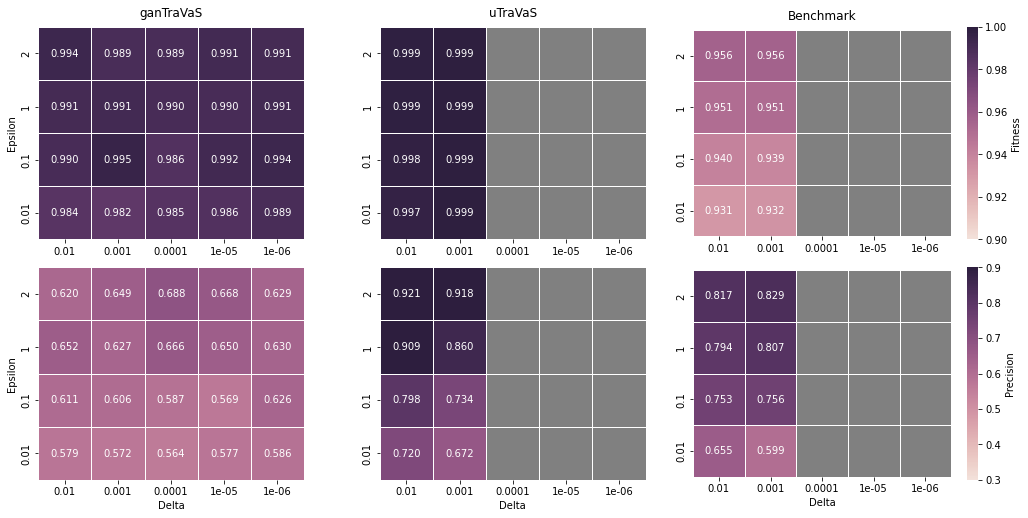

In [14]:
# create plots
f, ax = plt.subplots(2, 3, figsize=(14.8, 7.3))
cmap = sns.cubehelix_palette(as_cmap=True, light=.9)
cmap.set_bad('grey', 1.)
ax[0,0] = sns.heatmap(fit_gan_nondp, ax=ax[0,0], vmin=0.9, vmax=1, cmap=cmap, square=True, annot=True, cbar=False, fmt='.3f', yticklabels=[2,1,0.1,0.01], xticklabels=[0.01,0.001,0.0001,0.00001,0.000001], linewidths=.5)
ax[0,1] = sns.heatmap(fit_trav_nondp, ax=ax[0,1], vmin=0.9, vmax=1, cmap=cmap, square=True, annot=True, cbar=False, fmt='.3f', yticklabels=[2,1,0.1,0.01], xticklabels=[0.01,0.001,0.0001,0.00001,0.000001], mask=np.isnan(fit_trav_nondp), linewidths=.5)
ax[0,2] = sns.heatmap(fit_bench_nondp, ax=ax[0,2], vmin=0.9, vmax=1, cmap=cmap, square=True, annot=True, fmt='.3f', cbar=True, yticklabels=[2,1,0.1,0.01], xticklabels=[0.01,0.001,0.0001,0.00001,0.000001], mask=np.isnan(fit_bench_nondp), linewidths=.5, cbar_kws={'label': 'Fitness'})
ax[1,0] = sns.heatmap(prec_gan_nondp, ax=ax[1,0], cmap=cmap, square=True, vmin=0.3, vmax=0.9, annot=True, cbar=False, fmt='.3f', yticklabels=[2,1,0.1,0.01], xticklabels=[0.01,0.001,0.0001,0.00001,0.000001], linewidths=.5)
ax[1,1] = sns.heatmap(prec_trav_nondp, ax=ax[1,1], cmap=cmap, square=True, vmin=0.3, vmax=0.9, annot=True, cbar=False, fmt='.3f', yticklabels=[2,1,0.1,0.01], xticklabels=[0.01,0.001,0.0001,0.00001,0.000001], mask=np.isnan(prec_trav_nondp), linewidths=.5)
ax[1,2] = sns.heatmap(prec_bench_nondp, ax=ax[1,2], cmap=cmap, vmin=0.3, vmax=0.9, square=True, annot=True, fmt='.3f', cbar=True, yticklabels=[2,1,0.1,0.01], xticklabels=[0.01,0.001,0.0001,0.00001,0.000001], linewidths=.5, mask=np.isnan(prec_bench_nondp), cbar_kws={'label': 'Precision'})
ax[0,0].set_title('ganTraVaS', pad=10)
ax[0,1].set_title('uTraVaS', pad=10)
ax[0,2].set_title('Benchmark', pad=10)
ax[1,0].set(xlabel="Delta", ylabel="Epsilon")
ax[0,0].set(ylabel="Epsilon")
ax[1,1].set(xlabel="Delta")
ax[1,2].set(xlabel="Delta")
f.tight_layout()
plt.savefig("BPIC13_result-util-nondp.pdf")